# XY-calibration (All fields possible depending on initialization)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 

sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
CEg = 1.0187 # CEg = 1.02928 # 2018
Elg = 1.0090 # Elg = 1.00379 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


# QSO

In [22]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2022/XY/QSO1_XY_220718.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-QSO_-100.5.pkl"
save_filename = "Calibration/Mappings/2022/XY/QSO_XY_%s.pkl"%(datetime.datetime.now().strftime("%y%m%d"))
slits =['17', '6', '14', '1', '16', '7',"10","0","16"]
stars = [2, 4, 5, 6, 7]

# F1

In [35]:
# prerequisites:
Field = "F1"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F1_XY_220716.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F1_-60.pkl"
save_filename = "Calibration/Mappings/2022/XY/F1_XY_%s.pkl"%(datetime.datetime.now().strftime("%y%m%d"))
slits = ['46',  '35', '12','38']  # you should use more slits and with 206 line. These slits are only when we see 214
stars = [8, 25, 31]


# F2

In [37]:
# prerequisites:
Field = "F2"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F2_XY_220718.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F2_21.pkl"
save_filename = "Calibration/Mappings/2022/XY/F2_XY_%s.pkl"%(datetime.datetime.now().strftime("%y%m%d"))
slits =['3', '22','11', '20', '16', '18', '10', '5',"0"]
stars =[36, 40, 46, 21 ]


# F3

In [39]:
# prerequisites:
Field = "F3"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F3_XY_220717.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F3_60.pkl"
save_filename = "Calibration/Mappings/2022/XY/F3_XY_%s.pkl"%(datetime.datetime.now().strftime("%y%m%d"))
slits =['4', '13', '22', '12', '6', '23',"5","20","10"] # with 206
stars = [20, 5, 9]

# F4

In [41]:
# prerequisites:
Field = "F4"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F4_XY_220715.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F4_-20.pkl"
save_filename = "Calibration/Mappings/2022/XY/F4_XY_%s.pkl"%(datetime.datetime.now().strftime("%y%m%d"))
slits =['23', '36', '2', '13', '32', '11',"4"]
stars = [29, 34, 18, 14]


# For all fields

In [42]:
Hysteresis_compensation = False
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
    raise ValueError("Please be verify the value of Hysteresis_compensation")

# cat = Table.read(target_filename)
# mask_det_map = Mapping(mask_det_map_file)
# cat["X_IMAGE"] = mask_det_map.map(w=(1+cat["Z"])*0.121567 ,x=cat["x_mm"],y=cat["y_mm"])[0]
# cat["Y_IMAGE"] = mask_det_map.map(w=(1+cat["Z"])*0.121567,x=cat["x_mm"],y=cat["y_mm"])[1]
# cat.write(target_filename,overwrite=True)
# plt.plot(cat["y_mm"],cat["x_mm"],"o")
# plt.plot(cat["X_IMAGE"],cat["Y_IMAGE"],"o")

In [35]:
#load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)		
	
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')
# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n) \nYou can compare to the above table."%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.32252281, -0.04607301)>
FOV center pixel position in guider [array(1889.56720515), array(368.50657906)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV c

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

| Fields |    RA    |    DEC   | Angle | slits | Guide stars |
|:------:|:--------:|:--------:|:-----:|:-----:|:-----------:|
|   F1   |   32.19  |  -5.688  |   0   |   33  |      3      |
|   F2   | 253.0624 |  34.9699 |   20  |   23  |      3      |
|   F3   | 352.3424 |  0.21245 |   0   |   24  |      3      |
|   F4   |  36.9049 |  0.65245 |   0   |   25  |      4      |
|  QSO1  | 0.038940 | 1.394590 |   10  |   4   |      5      |
|  QSO5  | 14.62883 |  0.00512 |   10  |   6   |      2      |
|  QSO7  | 22.42638 |  0.62279 |  -20  |   6   |      3      |
|  QSO14 | 351.8533 |  -1.8553 |   0   |   2   |      5      |

In [8]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset

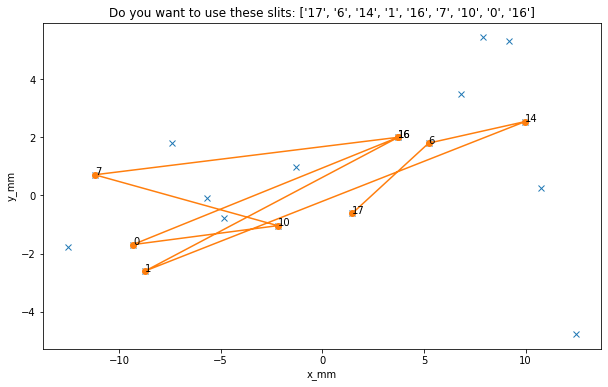

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
17,1.4615027187835672,-0.6202302818514861,22.45386,0.59717,-372.0397917012561,-83.9160000000002,381.386289298808
6,5.226252100742708,1.798431981021356,22.55721,0.62048,80259.99347189153,-3148.164,80321.71243617113
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-782.5319292155341,13.428000000000003,782.6471308487534
10,-2.197612879210593,-1.0379506376223713,14.581879999999998,-0.0281,-1213381.354398507,6722.007912,1213399.9738718986
0,-9.3221927436972,-1.689798368899516,351.63229675699995,-1.89532442,1212265.1211346844,-7064.763911999999,1212285.7067576204
16,3.734748022927276,2.000933456045201,14.70766,0.06711,0.0,0.0,0.0


In [9]:
F1['Internal-count'] = F1['Internal-count'].astype(str)
if "ra" in F1.colnames:
    ra,dec = "ra", "dec"
else: 
    ra,dec = "RA", "DEC"
if "x_mm" in F1.colnames:
    x,y = "x_mm", "y_mm"
else:
    x,y = "xmm", "ymm"


F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel(x)
plt.ylabel(y)
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

In [10]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))

moves.to_clipboard()
moves 


slit position in mm on mask: [ 1.46150272 -0.62023028]
slit position in mm on mask: [5.2262521  1.79843198]
slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [-2.19761288 -1.03795064]
slit position in mm on mask: [-9.32219274 -1.68979837]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 302.1 arcsec ; CE: 137.9 arcsec
EL: 404.7 arcsec ; CE: 293.7 arcsec
EL: 436.2 arcsec ; CE: 490.4 arcsec
EL: 218.3 arcsec ; CE: -283.2 arcsec
EL: 413.3 arcsec ; CE: 232.0 arcsec
EL: 358.5 arcsec ; CE: -385.9 arcsec
EL: 284.3 arcsec ; CE: -13.5 arcsec
EL: 256.7 arcsec ; CE: -308.3 arcsec
EL: 413.3 arcsec ; CE: 232.0 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==

,EL,CE,UV_image,EL_abs,CE_abs
0,302.059814,137.905953,True,302.059814,137.905953
1,102.626993,155.787202,True,404.686808,293.693155
2,31.538924,196.662749,True,436.225732,490.355904
3,-217.971999,-773.598245,True,218.253733,-283.242340
4,195.025476,515.216315,True,413.279209,231.973975
5,-54.732290,-617.843014,True,358.546919,-385.869039
6,-74.211524,372.358968,True,284.335395,-13.510071
7,-27.658749,-294.818659,True,256.676646,-308.328730
8,156.602563,540.302705,True,413.279209,231.973975


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [11]:

slits_coord_obs_det = np.array([
[ 1616.5,	1042.5 ],
[ 1778.5,	756.5  ],
[ 1830.5,	400.5  ],
[ 1494.5,	1808.9  ],
[ 1791.4,	868.4  ],
[ 1717.4,	1992.6  ],
[ 1590.5,	1316.6  ],
[ 1553.5,	1854.4  ],
[ 1791.4,	866.5  ]]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619 # 0.2139 # 0.20255
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )

if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
    raise ValueError("Please change obs_wave parameter (c)")


### look at siderostat frame hysteresis 

Fitting rotation, translation and magnification
gamma: 1.0309549563007483
theta: -99.9253436125352 arcmin
dx: -12.214654041281795 arcsec
dy: -111.30543803846919 arcsec
variances: [5.40202078e-04 1.85707795e+00 5.01891236e-01 5.01891236e-01]

residuals in arcsec: [[-0.86169147  3.2187391 ]
 [ 2.62508649  0.02155403]
 [-4.2126828  -2.57634481]
 [-2.57307988 -4.65357865]
 [ 2.68370203  1.24717716]
 [ 4.40345674 -2.03213971]
 [-0.69077625  4.42381769]
 [-4.11801325  1.20804356]
 [ 2.74399839 -0.85726838]]
max residual in EL,CE 4.4, 4.7 arcsec
mean residual in EL,CE 3.0, 2.7 arcsec


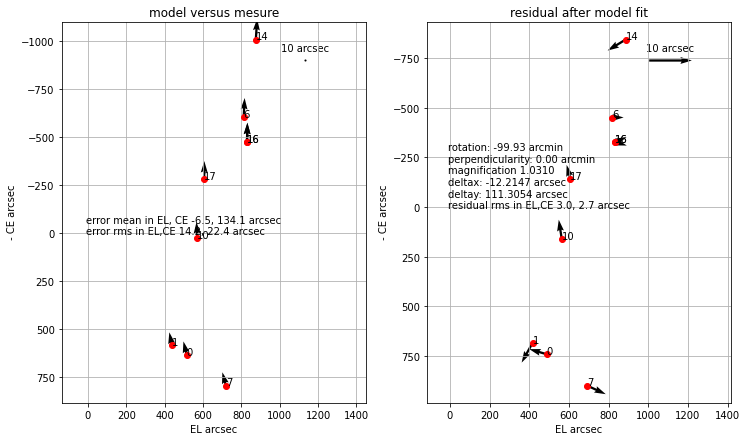

After updating:
    mask_rotation: -99.9253436125352 arcmin
    FOV center in guider: 1363.2898636170698 x 223.30676159491327 pix = 662.8022467381585 arcsec x -294.79234200060904 arcsec arcsec
    mask_magnification correction: 1.0309549563007483  
    


In [12]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits)


### save corrected model for future use

In [18]:
G2UVcor.save(filename=save_filename)

Dumping to Calibration/Mappings/2022/XY/F4_XY_220715.pkl


### Compute new moves (and compare to position of targets on the sky (does not work for QSO field which have different ra,dec)

slit position in mm on mask: [ 1.46150272 -0.62023028]
slit position in mm on mask: [5.2262521  1.79843198]
slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [-2.19761288 -1.03795064]
slit position in mm on mask: [-9.32219274 -1.68979837]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 299.6 arcsec ; CE: 206.9 arcsec
EL: 400.1 arcsec ; CE: 372.3 arcsec
EL: 426.6 arcsec ; CE: 578.7 arcsec
EL: 226.4 arcsec ; CE: -234.7 arcsec
EL: 410.8 arcsec ; CE: 308.2 arcsec
EL: 373.6 arcsec ; CE: -337.9 arcsec
EL: 286.1 arcsec ; CE: 48.7 arcsec
EL: 266.6 arcsec ; CE: -259.8 arcsec
EL: 410.8 arcsec ; CE: 308.2 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_18539/1504510991.py:14: RuntimeWarning: invalid value encountered in true_divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_18539/1504510991.py:15: RuntimeWarning: invalid value encountered in true_divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_18539/1504510991.py:16: RuntimeWarning: invalid value encountered in true_divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


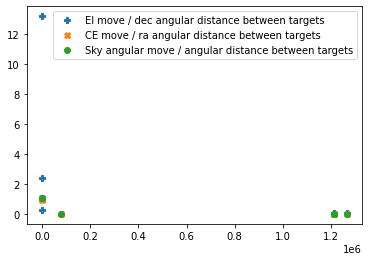

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
17,1.4615027187835672,-0.6202302818514861,22.45386,0.59717,-372.0397917012561,-83.9160000000002,381.386289298808,100.52939478157585,165.41054789874445,202.86831866922003,337.0074502889019,393.35680529247605,1.0313868545607034,-2.4175165483247483,-0.9058371115300355
6,5.226252100742708,1.798431981021356,22.55721,0.62048,80259.99347189153,-3148.164,80321.71243617113,26.459058800248247,206.37504962902162,53.39438065890096,420.46852611416864,423.8451855790849,0.005276844488542247,-0.0169604825729857,0.005238830803810421
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013,-200.19439535863398,-813.4294577414918,-403.99228983372336,-1657.2811772025152,1705.8108542727853,0.0013488766566537912,-0.032892278109565534,0.0013105634361470196
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966,184.4239983547855,542.957041257549,372.16762867995715,1106.2206758581303,1167.1473461107134,0.0009627364199160076,-0.052109811246634996,0.0009124961110899878
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643,-37.18502466300924,-646.1580343091248,-75.03937976995263,-1316.4823791014107,1318.6192638516889,1.0313933557795358,-0.2278560576991711,-1.065684979161256
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-782.5319292155341,13.428000000000003,782.6471308487534,-87.58578561560002,386.5859859132991,-176.7481153722808,787.6302876997555,807.2182891818376,1.0313949382353675,-13.162653810863924,-1.0065152082539717
10,-2.197612879210593,-1.0379506376223713,14.581879999999998,-0.0281,-1213381.354398507,6722.007912,1213399.9738718986,-19.435035959351072,-308.4560694518574,-39.21990256597046,-628.4483959012142,629.6710149499447,0.0005189311261814981,-0.005834551681493239,0.0005179314760549839
0,-9.3221927436972,-1.689798368899516,351.63229675699995,-1.89532442,1212265.1211346844,-7064.763911999999,1212285.7067576204,144.20584623796032,568.0281178476831,291.0073977082039,1157.3004873028694,1193.3271652955696,0.0009843613255882085,-0.04119138322710364,0.0009546595601295797
16,3.734748022927276,2.000933456045201,14.70766,0.06711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan


In [13]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_pandas().to_clipboard()
moves

new_cat = slit_path
new_cat["EL"] = list(moves["EL"][1:])+ [0]
new_cat["CE"] = list(moves["CE"][1:]) + [0]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()

plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

Here we just wanted to do another try to verify that the least square gives consistent results

# Go through the guide stars.
## Should do this step for F1, F2, F3, F4 and QSO field. For QSO field you should also run the couple of final cells

In [14]:
F1_stars = Table.read(star_target_path).to_pandas()
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
selected_stars

Internal count,RA,DEC,g mag,x deg,y deg,xmm_nicole,ymm_nciole
int64,float64,float64,float64,float64,float64,float64,float64
2,0.064613,1.207946,11.823838,-0.007133,-0.188265,-0.301159,-7.948758
4,359.996741,1.239476,11.899264,-0.068484,-0.145431,-2.892193,-6.141819
5,0.002719,1.247124,11.21874,-0.06127,-0.138937,-2.587725,-5.868035
6,0.0266,1.331968,9.07557,-0.023024,-0.059529,-0.972906,-2.51548
7,0.038536,1.289373,10.086621,-0.018669,-0.103549,-0.788729,-4.374788


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

In [15]:
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves
# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -7.0 arcsec ; CE: 122.4 arcsec
EL: 72.6 arcsec ; CE: 16.2 arcsec
EL: 83.8 arcsec ; CE: 29.3 arcsec
EL: 223.4 arcsec ; CE: 101.0 arcsec
EL: 144.7 arcsec ; CE: 106.4 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,-7.040060,122.417444,1.0
1,79.595297,-106.203583,1.0
2,11.210659,13.080273,1.0
3,139.677784,71.657492,1.0
4,-78.755097,5.434114,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

# Only for QSO
---------------------------

In [16]:
stars = [8, 10, 12] #QSO7
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(22.42638*u.deg, 0.62279*u.deg), rotation=(90-70)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
selected_stars


Internal count,RA,DEC,g mag,x deg,y deg,xmm_nicole,ymm_nciole
int64,float64,float64,float64,float64,float64,float64,float64
8,22.374342,0.385839,11.857352,0.032143,-0.240459,1.356271,-10.146112
10,22.470774,0.374579,7.73287,0.12661,-0.218059,5.341594,-9.199783
12,22.455571,0.580502,10.246187,0.041892,-0.029754,1.770297,-1.257362


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

In [18]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
star_moves



targets local coords in siderostat local frame:
EL: -102.2 arcsec ; CE: 189.1 arcsec
EL: -67.1 arcsec ; CE: 357.2 arcsec
EL: 273.2 arcsec ; CE: 217.2 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,-102.186452,189.135905,1.0
1,35.061442,168.067310,1.0
2,340.317892,-140.018695,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

----------------------------

In [19]:
stars = [13,14] #QSO5
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(14.62883*u.deg, 0.00512*u.deg), rotation=(90-100)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
selected_stars.to_pandas().to_clipboard()
selected_stars

Internal count,RA,DEC,g mag,x deg,y deg,xmm_nicole,ymm_nciole
int64,float64,float64,float64,float64,float64,float64,float64
13,14.779574,-0.145077,8.382003,0.122372,-0.174092,5.165337,-7.348422
14,14.642088,-0.25461,11.709938,-0.032045,-0.258086,-1.351831,-10.88735


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

In [20]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
star_moves



targets local coords in siderostat local frame:
EL: 11.5 arcsec ; CE: 352.0 arcsec
EL: -130.3 arcsec ; CE: 74.8 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,11.529247,351.975036,1.0
1,-141.834204,-277.162211,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

----------------------------

In [21]:
stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(351.8533*u.deg, -1.8553*u.deg), rotation=0*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363

selected_stars.to_pandas().to_clipboard()
selected_stars

Internal count,RA,DEC,g mag,x deg,y deg,xmm_nicole,ymm_nciole
int64,float64,float64,float64,float64,float64,float64,float64
17,351.719117,-1.990274,10.760506,-0.134103,-0.13498,-5.661853,-5.698882
18,351.915116,-1.887787,10.212835,0.061782,-0.032488,2.61064,-1.372815
19,351.917335,-1.86546,9.717599,0.064001,-0.010161,2.704453,-0.42938
20,351.944342,-1.952026,9.897263,0.09099,-0.096728,3.843519,-4.085917
21,351.947933,-2.004666,11.121481,0.094576,-0.149369,3.993547,-6.307


In [22]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
star_moves


targets local coords in siderostat local frame:
EL: 94.6 arcsec ; CE: -99.2 arcsec
EL: 267.3 arcsec ; CE: 252.2 arcsec
EL: 307.0 arcsec ; CE: 257.3 arcsec
EL: 151.2 arcsec ; CE: 300.5 arcsec
EL: 57.1 arcsec ; CE: 304.1 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,94.603005,-99.194811,1.0
1,172.681476,351.383658,1.0
2,39.714966,5.066915,1.0
3,-155.830699,43.240719,1.0
4,-94.093264,3.632538,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://drive.google.com/open?id=1VBm8cv2qf9k8MZZmbUK5YKn10usmbJXw&authuser=vp2376%40columbia.edu&usp=drive_fs)

----------------------------